In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import jax
import jax.numpy as jnp
import scipy.stats as stats
import math
import csv
#from jax import grad, jit, devices
#import autograd.numpy as jnp
#from autograd import grad

In [3]:
def func_reshape(image, max_size):
    p = len(image)
    if p < max_size:
        image = jnp.hstack((jnp.zeros((p,(max_size-p)//2)), image, jnp.zeros((p,(max_size-p)//2))))
        image = jnp.vstack((jnp.zeros(((max_size-p)//2,max_size)), image, jnp.zeros(((max_size-p)//2,max_size))))
    return image

In [3]:
# lam_x = np.loadtxt('6V_Wavelength.csv', dtype=np.int32)
# inten_x = np.loadtxt('6V_Intensity.csv', dtype=np.float32)
# lam_x = np.array(lam_x)/1e+3
# inten_x = np.array(inten_x)

# max_index = inten_x.argmax()
# lam_depth = len(lam_x)

# lam = lam_x[max_index]

# plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
# plt.title('The spectrum of LED laser')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Intensity')
# plt.show()

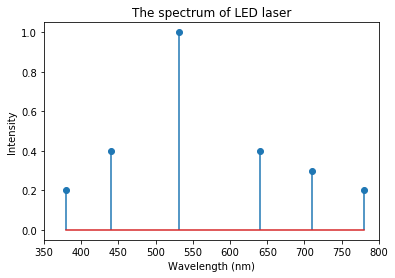

In [4]:
lam_x = np.array([0.380, 0.440, 0.532, 0.640, 0.710, 0.780])
inten_x = np.array([0.2, 0.4, 1, 0.4, 0.3, 0.2])

max_index = inten_x.argmax()
lam_depth = len(lam_x)

lam = lam_x[max_index]

plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
plt.xlim(350,800)
plt.title('The spectrum of LED laser')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

target image size:  2048 x 2048


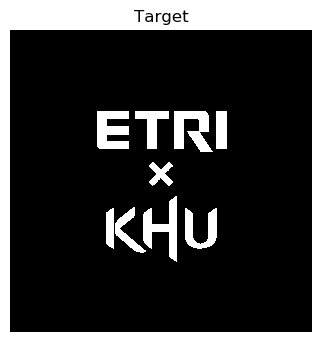

The number of SLM pixels:  4194304
The number of IMG pixels:  4194304
focal length:  15.398496240601505 mm
SLM pitch: 2.0 (um)
IMG pitch: 2.0 (um)
SLM size:  4096.0 (um) x 4096.0 (um)
IMG size:  4096.0 (um) x 4096.0 (um)
Fresnel number:  512.0
Refractive index:  0.6


In [5]:
%matplotlib inline

logo = plt.imread('EK_1616x1616.png')[:,:,0]
ll, mm = 1616, 2048

logo = (logo>0.5)*1

logo = np.hstack((np.zeros((ll,(mm-ll)//2)),logo,np.zeros((ll,(mm-ll)//2))))
logo = np.vstack((np.zeros(((mm-ll)//2,mm)),logo,np.zeros(((mm-ll)//2,mm))))

# logo = logo[::16,::16]
# logo = np.kron(logo, np.ones((2,2)))
logo = logo.astype(np.int8)

p = logo.shape[0]                # pxp target image
m = p*p                          # number of pixels in target image
m_b = int(np.sum(logo))          # number of bright pixels
m_d = m - m_b                    # number of dark pixels

target_coords = np.where( logo > 0 )

target = logo
print("target image size: ",p,"x",p)
plt.figure(dpi=100, figsize=(4,4))
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.show()

d_n = 0.6                        # Refractive index of Photoresist : 1.6
q   = int(1.0*p)
d   = 2.0              # pitch: 2 micrometer
f   = p/lam*4

max_size = int(p*lam_x[-1]/lam)
max_size += max_size%2

# list of SLM pixels contained in the pupil
slm_x, slm_y = np.meshgrid( np.arange(q), np.arange(q) )
slm_x = ( slm_x - int(q/2) ) * d
slm_y = ( slm_y - int(q/2) ) * d
slm_x = slm_x.astype(np.float32)
slm_y = slm_y.astype(np.float32)

# quad_phase = np.zeros((q,q,), dtype=np.complex64)
# quad_phase = np.exp(1j*np.pi/(lam*f)*( slm_x**2 + slm_y**2 ))

pup_ind = np.kron(range(q),np.ones(q,dtype=np.int8)), \
          np.kron(np.ones(q,dtype=np.int8),range(q))

n = pup_ind[0].shape[0]

SLM_size = d*q         # in um
IMG_size = lam*f/d     # in um
IMG_pitch = IMG_size/p # in um


#px = ( px_ind - int(p/2) ) * IMG_pitch
#py = ( py_ind - int(p/2) ) * IMG_pitch
#pz = ( py_ind*0 + f )

print("The number of SLM pixels: ",n)
print("The number of IMG pixels: ",m)
print("focal length: ",f*1e-3,"mm")
print("SLM pitch:",d,"(um)")
print("IMG pitch:", IMG_pitch,"(um)")
print("SLM size: ", SLM_size, "(um) x", SLM_size, "(um)")
print("IMG size: ", IMG_size, "(um) x", IMG_size, "(um)")
print("Fresnel number: ", SLM_size**2/4/lam/f)
print("Refractive index: ", d_n)

In [6]:
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))

print('lam_depth :',lam_depth)

lam_depth : 6


# random superposition (단일 파장 고려)

In [7]:
# wf = np.zeros((q,q), dtype=np.complex64)
# wf_slm = np.zeros((q,q), dtype=np.complex64)

# pists = np.random.rand(m_b)*2*np.pi
# pists = pists.astype(np.float32)

# wf[target_coords] = np.exp(1j*pists)
# wf *= quad_phase_3d[:,:,0] # lam = 532nm
# wf *= np.exp(1j*2*np.pi*f/lam)/(1j*lam*f)

# wf_slm += np.fft.ifft2(wf/(np.exp(1j*2*np.pi*f/lam)/(1j*lam*f))) * np.exp(-1j*2*np.pi/lam*f)/quad_phase_3d[:,:,0]*(1j*lam*f)

# phase_rs = np.angle(wf_slm)
# phase_rs = phase_rs.astype(np.float32)

# del wf, wf_slm

# d_n = 0.6                        # Refractive index of Photoresist : 1.6

# LC_d_rs = phase_rs * lam/(2*np.pi*d_n) # in um

# intensity_rs = np.zeros((p,p), dtype=np.float32)

# for i in range(lam_depth):
#     phase_rs = LC_d_rs*2*np.pi*d_n/lam_x[i]
#     xxx = np.exp(1j*phase_rs)*quad_phase_3d[:,:,i]
#     zzz = inten_x[i]*np.fft.fft2(xxx)/n
#     intensity_rs += np.abs(zzz)**2

# print("RS maximum intensity: ",intensity_rs.max())
# print("RS minimum intensity: ",intensity_rs.min())

# random superposition (여러 파장 고려)

RS maximum intensity:  1.4222057e-13
RS minimum intensity:  1.4356704e-17


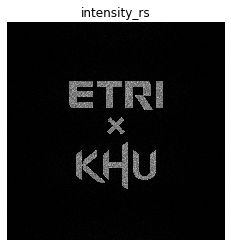

In [7]:
wf = np.zeros((q,q,lam_depth), dtype=np.complex64)
wf_slm = np.zeros((q,q,lam_depth), dtype=np.complex64)
phase_rs = np.zeros((q,q,lam_depth), dtype=np.complex64)

for i in range(lam_depth):
    pists = np.random.rand(m_b)*2*np.pi
    pists = pists.astype(np.float32)
    
    wf[:,:,i][target_coords] = np.exp(1j*pists)
    wf[:,:,i] *= quad_phase_3d[:,:,i]
    wf[:,:,i] *= np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)

    wf_slm[:,:,i] = np.fft.ifft2(wf[:,:,i]/(np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f))) \
    * np.exp(-1j*2*np.pi/lam_x[i]*f)/quad_phase_3d[:,:,i]*(1j*lam_x[i]*f)
    
    phase_rs[:,:,i] = np.angle(wf_slm[:,:,i]).astype(np.float32)

del wf, wf_slm

d_n = 0.6                        # Refractive index of Photoresist : 1.6

# LC_d_rs는 phase_rs[:,:,max_index]으로 생성한 LC_d이다.
LC_d_rs = phase_rs[:,:,max_index]*lam_x[max_index]/(2*np.pi*d_n)

intensity_rs = np.zeros((p,p), dtype=np.float32)

for i in range(lam_depth):
    xxx = np.exp(1j*phase_rs[:,:,i])*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    intensity_rs += np.abs(zzz)**2

del xxx, zzz

print("RS maximum intensity: ",intensity_rs.max())
print("RS minimum intensity: ",intensity_rs.min())

plt.imshow(intensity_rs,cmap='gray')
plt.axis('off')
plt.title('intensity_rs')
plt.show()

# intensity_desired 및 e_image 설정

desired intensity(rs):  6.998815047475071e-14


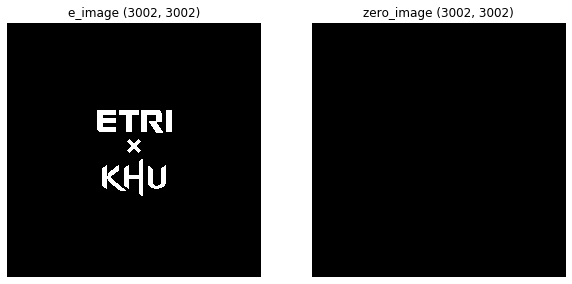

In [28]:
intensity_desired = np.mean(intensity_rs[target>0]) * 1.0
print("desired intensity(rs): ",intensity_desired)

# expected image
e_image = target*intensity_desired
e_image = func_reshape(e_image, max_size)

zero_image = np.zeros((e_image.shape))

e_size_x,e_size_y = e_image.shape
zero_size_x,zero_size_y = zero_image.shape

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title(f'e_image {e_size_x,e_size_y}')
plt.imshow(e_image, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title(f'zero_image {zero_size_x,zero_size_y}')
plt.imshow(zero_image, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
filename_1 = 'LC_d_ls_1_%dx%d' %(p,p)
LC_d_ls_1 = np.loadtxt(filename_1+'.csv', dtype=np.float32)

intensity_ls_1 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    phase_ls_1 = LC_d_ls_1*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_1)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls_1 += np.abs(zzz)**2
del xxx, zzz

print('LS_1')

LS_1


In [11]:
filename_2 = 'LC_d_ls_2_%dx%d' %(p,p)
LC_d_ls_2 = np.loadtxt(filename_2+'.csv', dtype=np.float32)

intensity_ls_2 = np.zeros((max_size,max_size), dtype=np.float32)

for i in range(lam_depth):
    phase_ls_2 = LC_d_ls_2*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_2)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls_2 += np.abs(zzz)**2
del xxx, zzz

print('LS_2')

LS_2


In [12]:
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

gpus = jax.devices('gpu')

# lam_x (여러 개 고려, 전부 중첩)
def loss0(LC_d):
    # z = jnp.zeros((max_size,max_size), dtype=np.float32)
    intensity_loss = jnp.zeros((max_size,max_size))
    for i in range(lam_depth):
        img_size = int(p*lam_x[i]/lam)
        img_size += img_size%2
        phi = LC_d*2*jnp.pi*d_n/lam_x[i]
        z = inten_x[i]*jnp.exp(1j*2*jnp.pi*f/lam_x[i]) \
        /(1j*lam_x[i]*f)*jnp.fft.fft2(jnp.exp(1j*phi)*quad_phase_3d[:,:,i])/n
        z = jnp.abs(z)**2
        z = jax.image.resize(z, (img_size, img_size), "nearest")
        z = func_reshape(z, max_size)
        intensity_loss += z
    return 1.0e18*n*jnp.linalg.norm(intensity_loss - e_image)**2

grad0 = jax.grad(loss0)
loss0 = jax.jit(loss0, device=gpus[0])
grad0 = jax.jit(grad0, device=gpus[0])

# lam_x (여러 개 고려, 특정 부분만 밝게)
def loss1(LC_d):
    # z = jnp.zeros((max_size,max_size), dtype=np.float32)
    loss_return = 0
    intensity_loss = jnp.zeros((max_size,max_size,lam_depth))
    for i in range(lam_depth):
        img_size = int(p*lam_x[i]/lam)
        img_size += img_size%2
        phi = LC_d*2*jnp.pi*d_n/lam_x[i]
        z = inten_x[i]*jnp.exp(1j*2*jnp.pi*f/lam_x[i]) \
        /(1j*lam_x[i]*f)*jnp.fft.fft2(jnp.exp(1j*phi)*quad_phase_3d[:,:,i])/n
        z = jnp.abs(z)**2
        z = jax.image.resize(z, (img_size, img_size), "nearest")
        z = func_reshape(z, max_size)
        intensity_loss[:,:,i] += z
    for j in range(lam_depth):
        if j == max_index:
            loss_return += 1.0e18*n*jnp.linalg.norm(intensity_loss[:,:,j] - e_image)**2
        else:
            loss_return += 1.0e18*n*jnp.linalg.norm(intensity_loss[:,:,j] - zero_image)**2
    return loss_return

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


# loss0으로 계산한 결과  
-> 전부 중첩

# loss1으로 계산한 결과  
-> 특정 부분만 밝게

 iter |            loss |       norm_grad |       norm_move |       step_size


/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


    0 |        657.2081 |         15.2764 |       1466.5333 |         96.0000
    1 |        657.2081 |         15.2764 |        733.2668 |         48.0000
    2 |        657.2082 |         15.2764 |        366.6334 |         24.0000
    3 |        657.2083 |         15.2764 |        183.3167 |         12.0000
    4 |        620.9399 |         15.2764 |        219.9800 |         14.4000
    5 |        620.9399 |          5.8182 |         41.8910 |          7.2000
    6 |        509.8611 |          5.8182 |         50.2692 |          8.6400
    7 |        485.9536 |          2.6007 |         26.9638 |         10.3680
    8 |        472.2351 |          2.2280 |         27.7197 |         12.4416
    9 |        472.2351 |          2.6718 |         16.6206 |          6.2208
   10 |        453.0716 |          2.6718 |         19.9448 |          7.4650
   11 |        441.4920 |          1.5979 |         14.3141 |          8.9580
   12 |        430.5249 |          1.3973 |         15.0208 |   

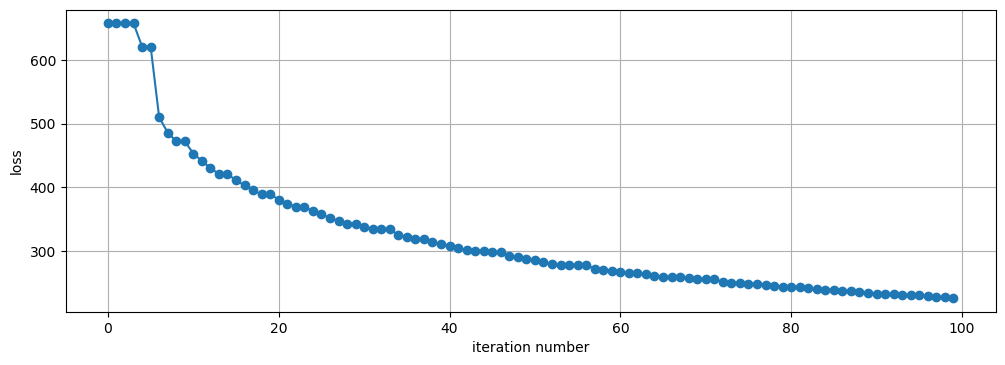

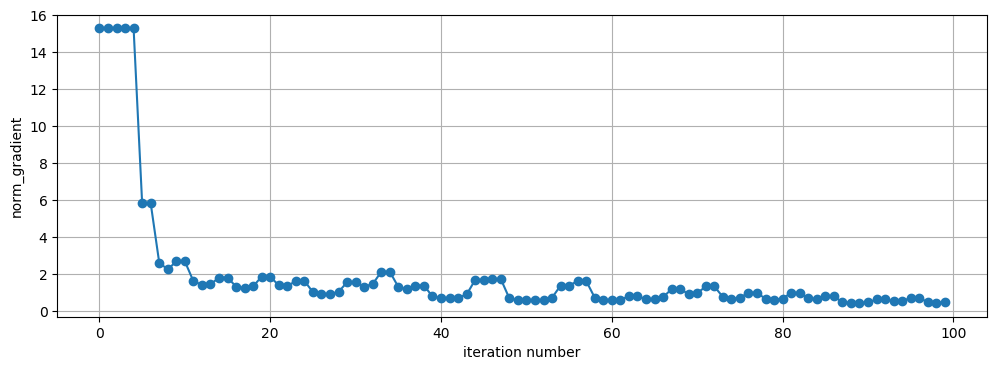

CPU times: user 13.1 s, sys: 4.09 s, total: 17.2 s
Wall time: 19.9 s


In [13]:
%%time

LC_d = copy.deepcopy(LC_d_rs)

max_iter = 100
loss_hist = np.zeros(max_iter, dtype=np.float32)
grad_hist = np.zeros(max_iter, dtype=np.float32)
move_hist = np.zeros(max_iter, dtype=np.float32)

# step_size = 12*(q/512)**2
step_size = 12*(q/512)**2


print(" iter |            loss |       norm_grad |       norm_move |       step_size")
print("=============================================================================")

for i in range(max_iter):
    grad_cur = np.asarray(grad0(LC_d)) ## grad1
    loss_cur = np.asarray(loss0(LC_d)) ## loss1
    temp = (LC_d - step_size * grad_cur).astype(np.float32)
    loss_new = np.asarray(loss0(temp)) ## loss1
    
    if loss_new < loss_cur:
        step_size *= 1.2
        LC_d = temp
        loss_cur = loss_new
    else:
        step_size *= 0.5
        
    loss_hist[i] = loss_cur
    grad_hist[i] = np.linalg.norm(grad_cur,'fro')
    move_hist[i] = step_size*grad_hist[i]
    print( "%5d |%16.4f |%16.4f |%16.4f |%16.4f" % (i,loss_hist[i],grad_hist[i],move_hist[i],step_size) )
print("=============================================================================")


print('loss :', loss_hist[-1])
print('grad :', grad_hist[-1])


plt.figure(figsize=(12,4), dpi=100)
plt.plot(range(max_iter), loss_hist, 'o-')
plt.grid()
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(12,4), dpi=100)
plt.plot(range(max_iter), grad_hist, 'o-')
plt.grid()
plt.xlabel("iteration number")
plt.ylabel("norm_gradient")
plt.show()


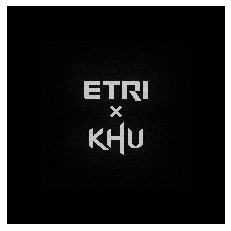

In [14]:
LC_d_ls_3 = copy.deepcopy(LC_d)

intensity_ls_3 = np.zeros((max_size,max_size), dtype=np.float32)
for i in range(lam_depth):
    phase_ls_3 = LC_d_ls_3*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_ls_3)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    img_size = int(p*lam_x[i]/lam)
    img_size += img_size%2
    zzz = jax.image.resize(zzz, (img_size, img_size), "nearest")
    zzz = func_reshape(zzz, max_size)
    intensity_ls_3 += np.abs(zzz)**2
del xxx, zzz

plt.imshow(intensity_ls_3, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
filename_3 = 'LC_d_ls_3_%dx%d' %(p,p)
print(filename_3)
plt.imsave(filename_3+'.png', LC_d_ls_3, format='png', cmap='gray')
np.savetxt(filename_3+'.csv', LC_d_ls_3, fmt='%f')

LC_d_ls_3_2048x2048


Maximum intensity (LS_1):  8.8484335e-14
Maximum intensity (LS_2):  9.38159e-14
Maximum intensity (LS_3):  7.6327094e-14

Minimum intensity (LS_1):  1.4454856e-22
Minimum intensity (LS_2):  9.9155764e-23
Minimum intensity (LS_3):  1.7942021e-23


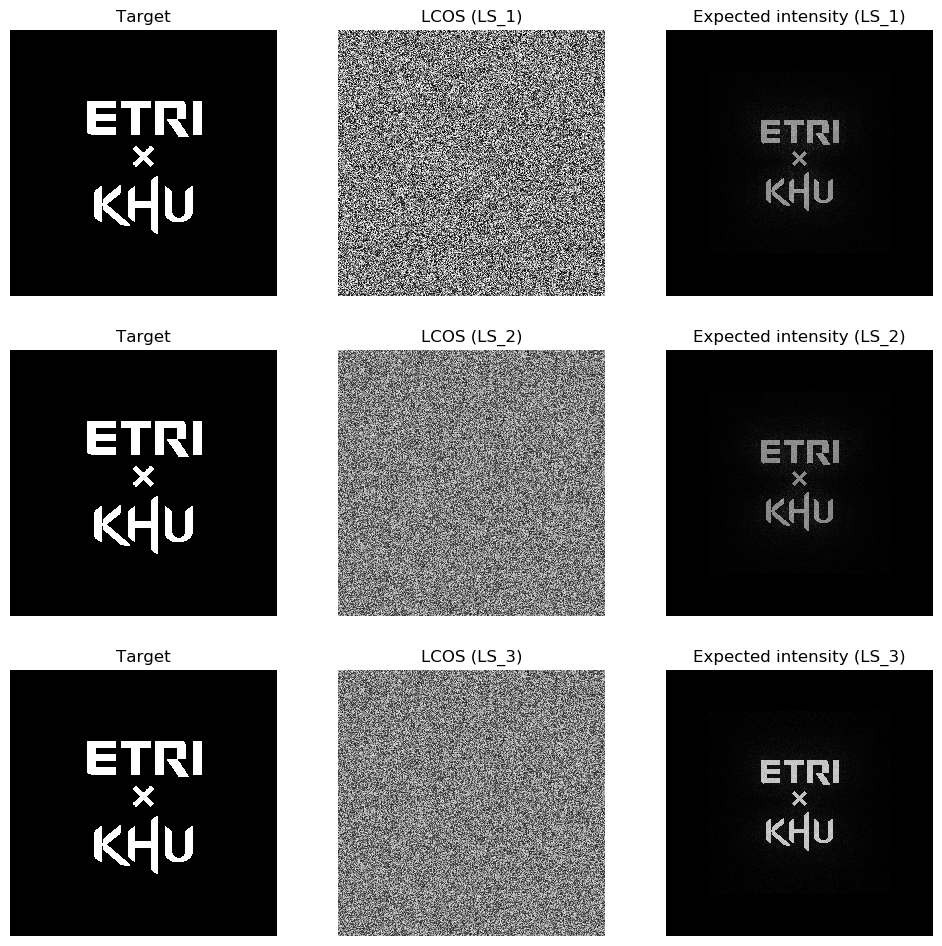

In [16]:
print("Maximum intensity (LS_1): ",intensity_ls_1.max())
print("Maximum intensity (LS_2): ",intensity_ls_2.max())
print("Maximum intensity (LS_3): ",intensity_ls_3.max())
print("")
print("Minimum intensity (LS_1): ",intensity_ls_1.min())
print("Minimum intensity (LS_2): ",intensity_ls_2.min())
print("Minimum intensity (LS_3): ",intensity_ls_3.min())

plt.figure(dpi=100, figsize=(12,12))

plt.subplot(331)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(332)
plt.imshow(LC_d_ls_1, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_1)')
plt.subplot(333)
plt.imshow(intensity_ls_1, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_1)')

plt.subplot(334)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(335)
plt.imshow(LC_d_ls_2, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_2)')
plt.subplot(336)
plt.imshow(intensity_ls_2, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_2)')

plt.subplot(337)
plt.imshow(target, cmap='gray')
plt.axis('off')
plt.title('Target')
plt.subplot(338)
plt.imshow(LC_d_ls_2, cmap='gray')
plt.axis('off')
plt.title('LCOS (LS_3)')
plt.subplot(339)
plt.imshow(intensity_ls_3, cmap='gray')
plt.axis('off')
plt.title('Expected intensity (LS_3)')

plt.show()

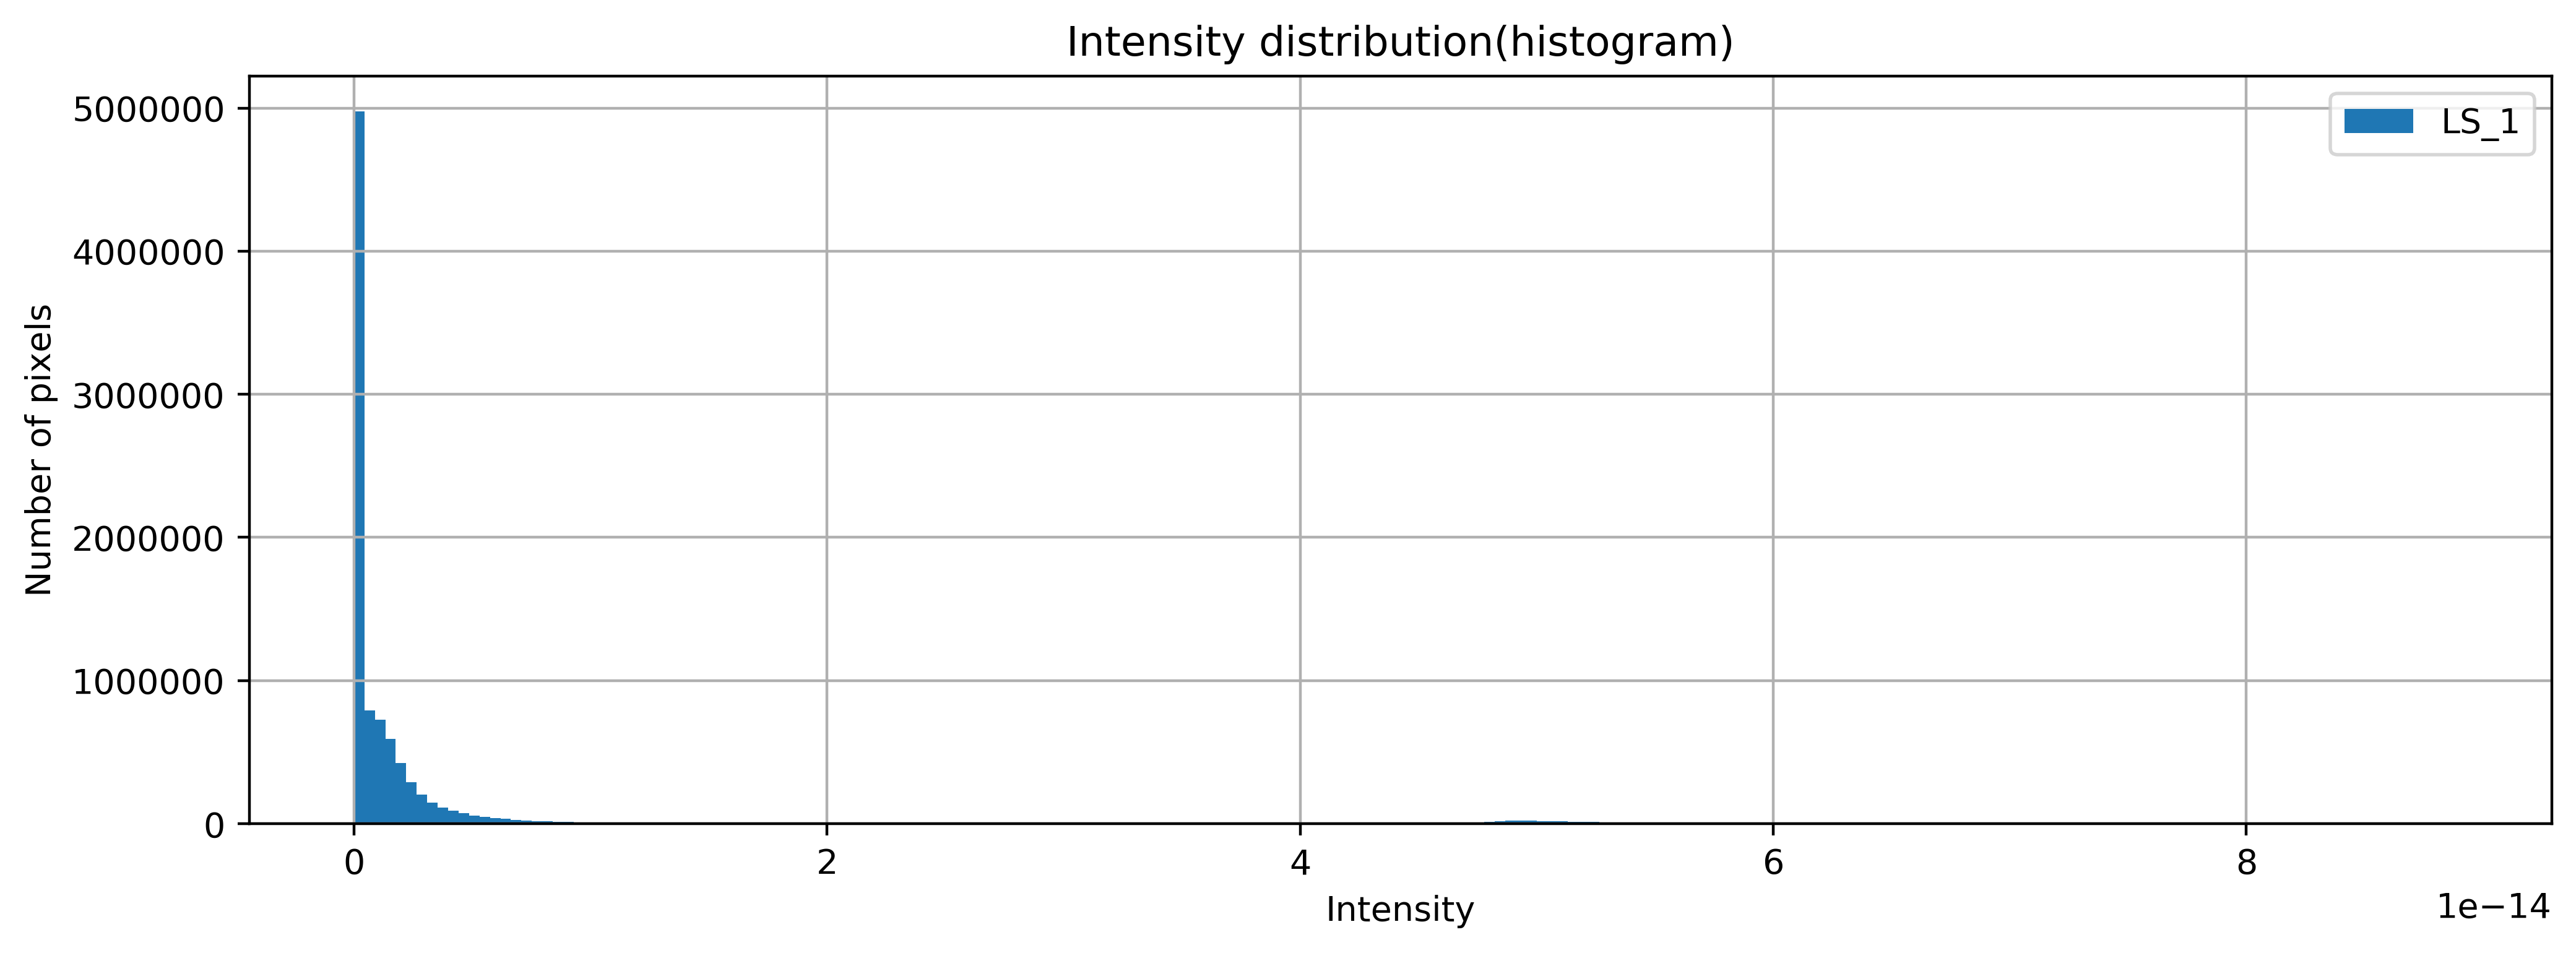

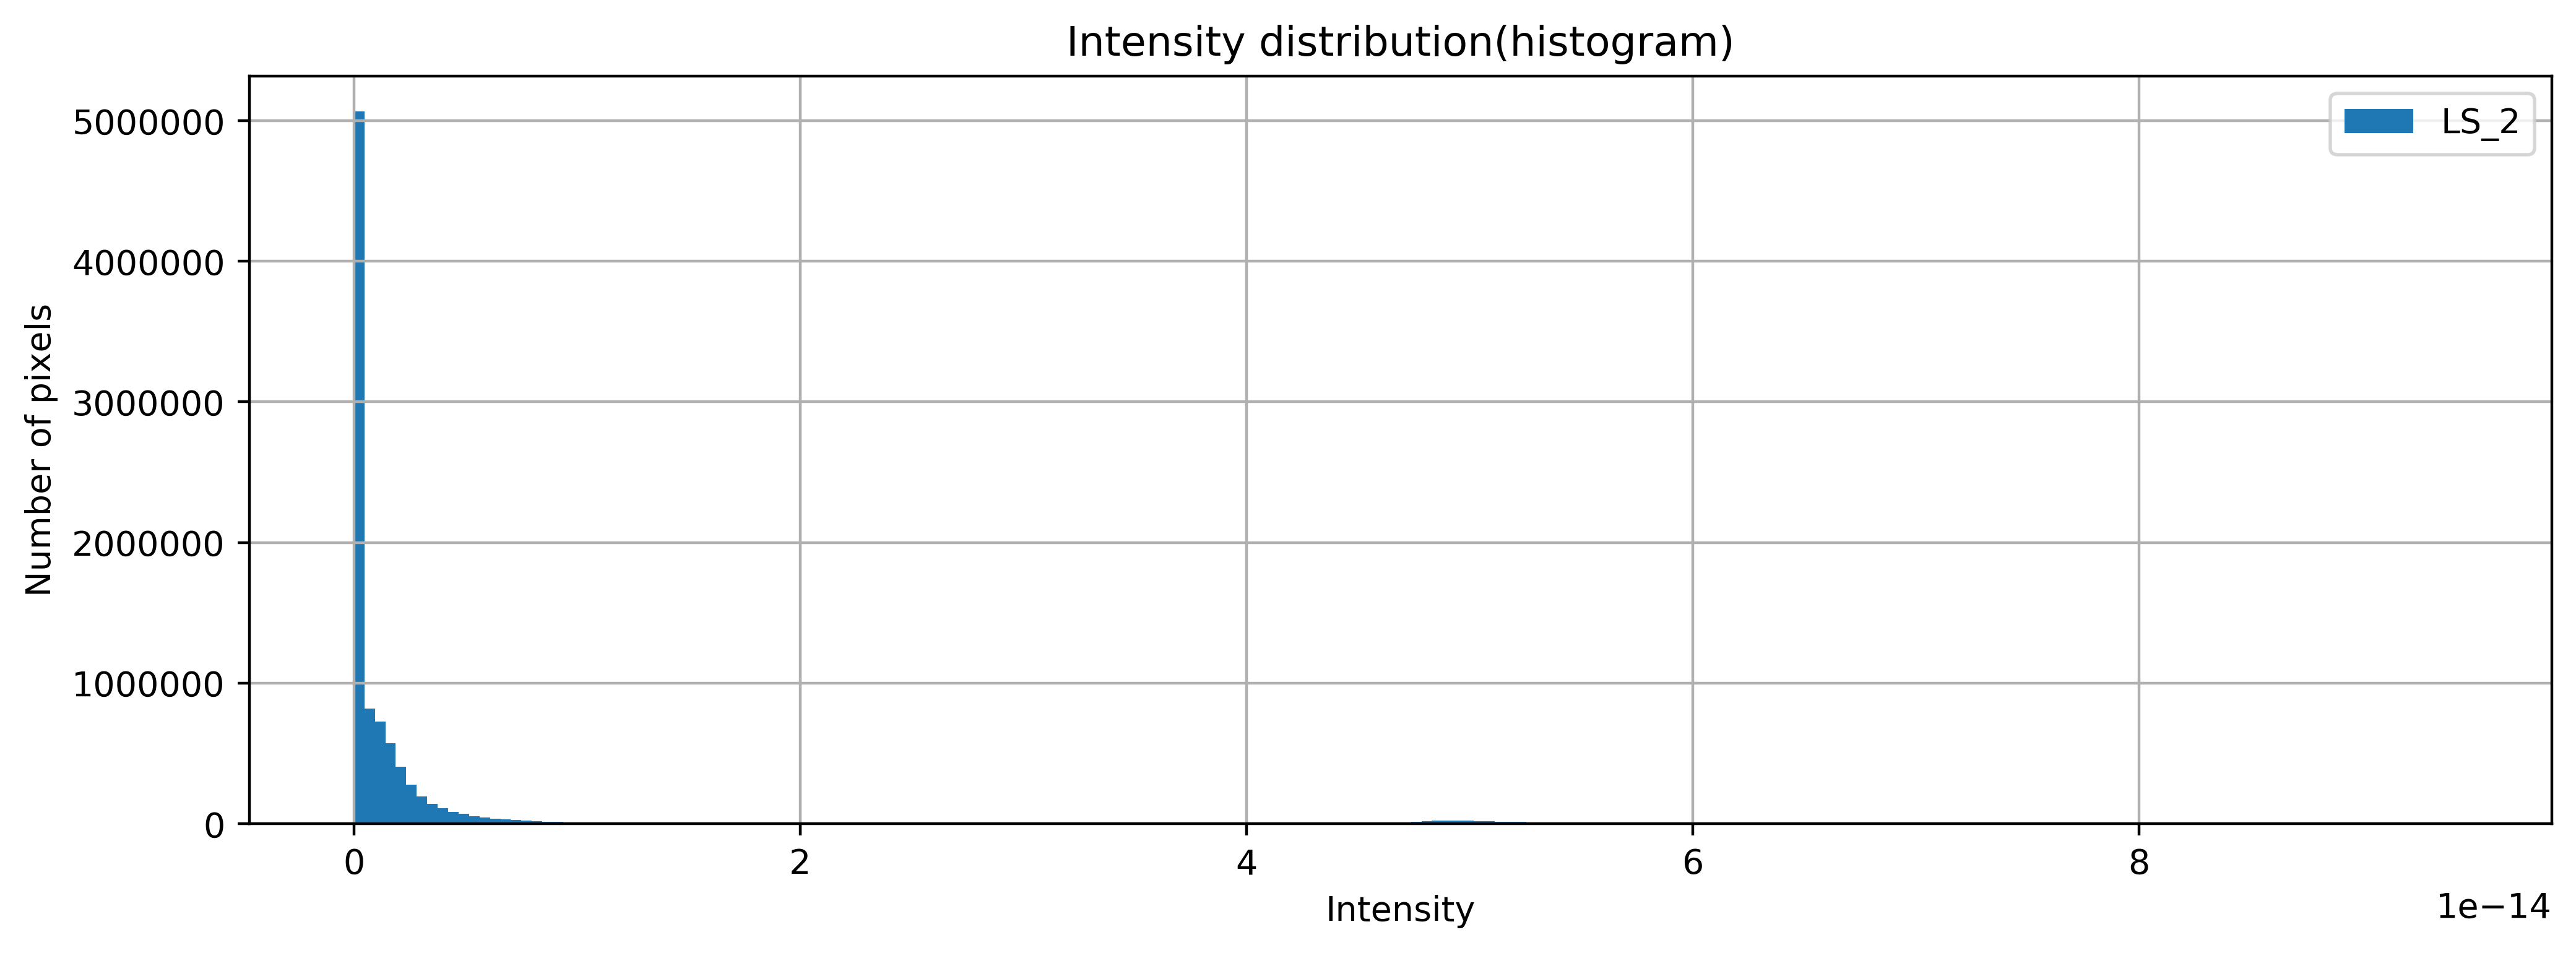

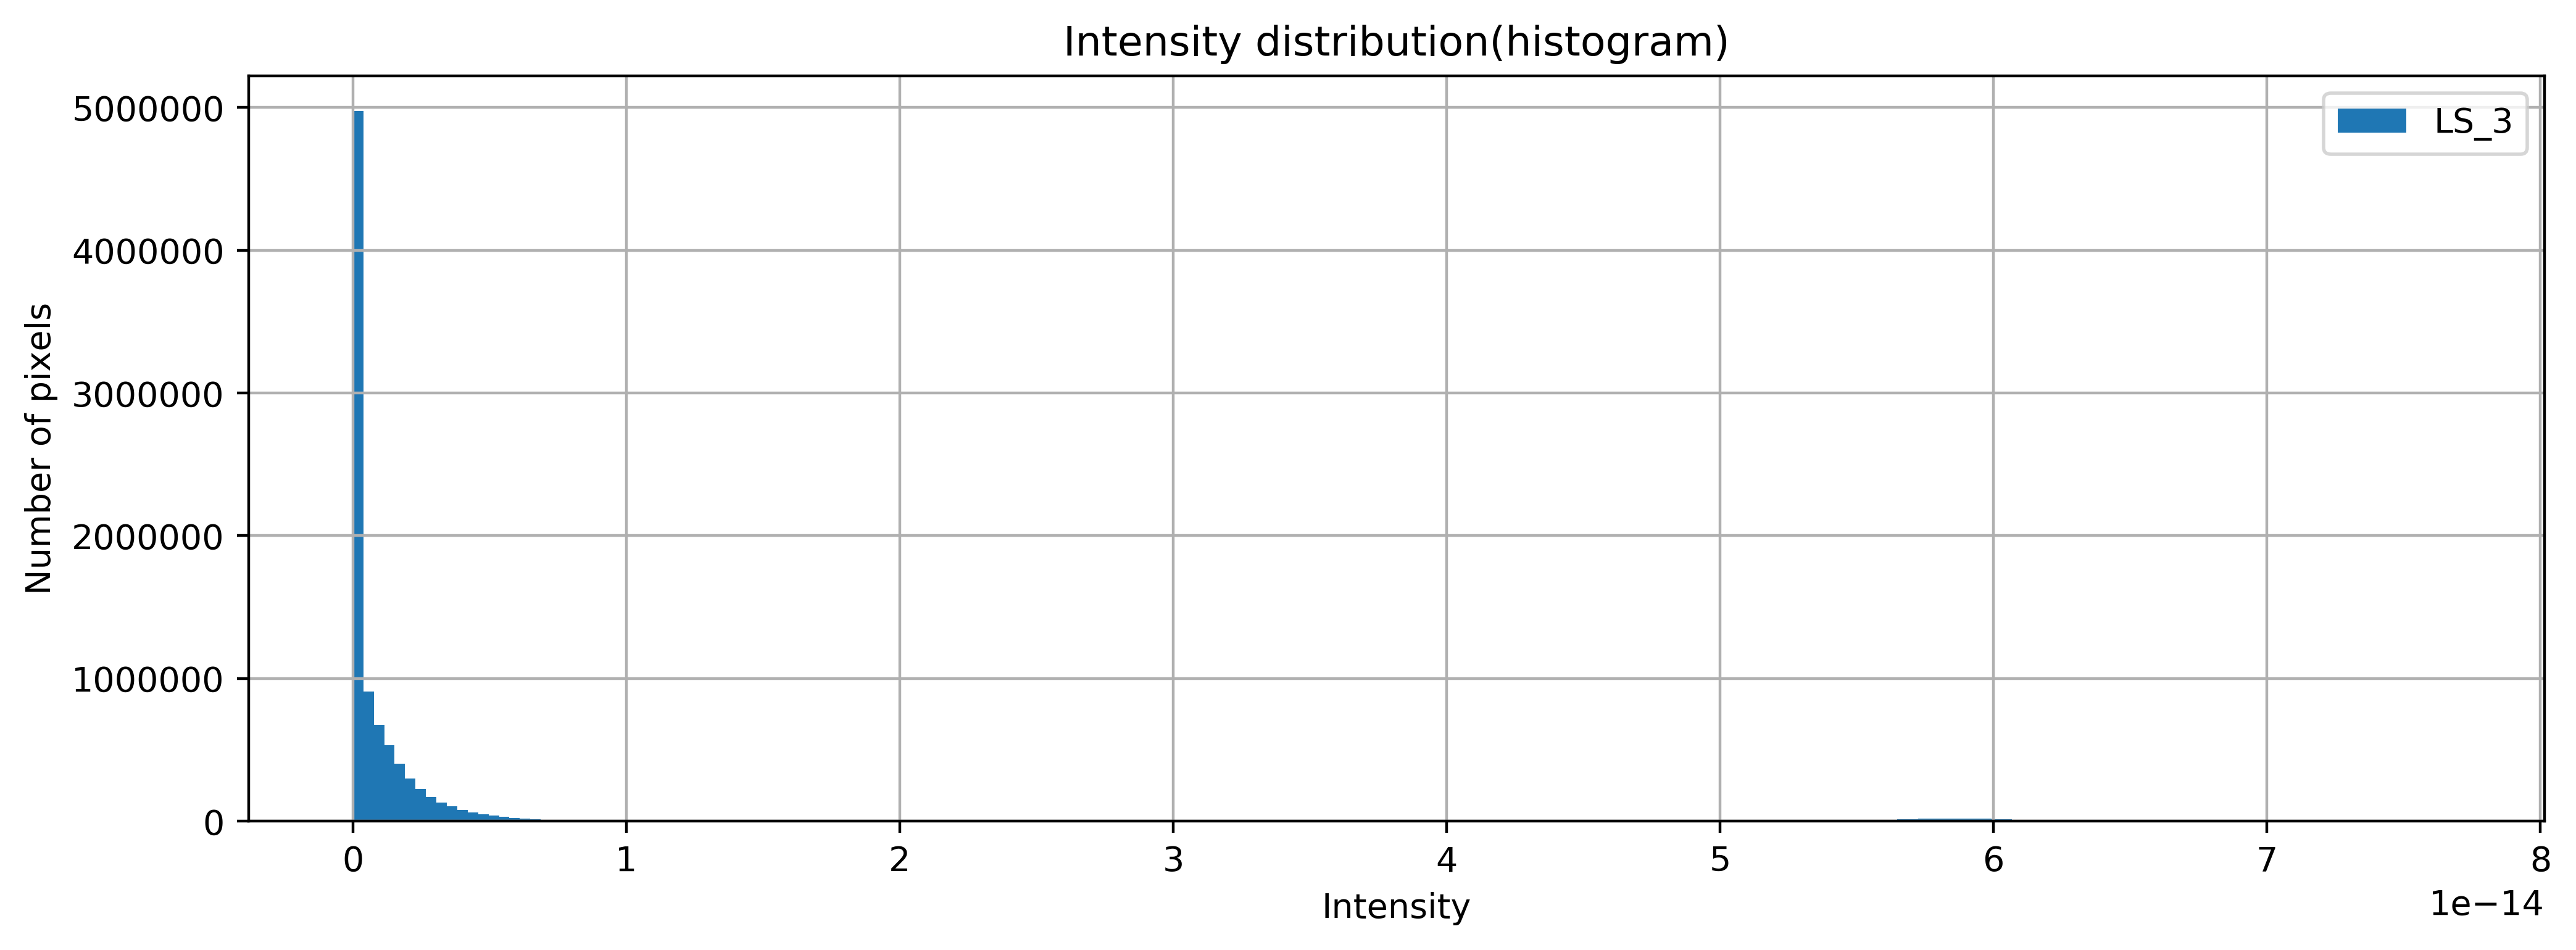

In [17]:
plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_1.flatten(),200,label='LS_1')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram)')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_2.flatten(),200,label='LS_2')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram)')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

plt.figure(dpi=400, figsize=(12,4))
plt.hist(intensity_ls_3.flatten(),200,label='LS_3')
# plt.xlim(0,4e-07)
plt.title('Intensity distribution(histogram)')
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.legend()
plt.grid()
plt.show()

target image intensity  
1e+18 곱하는거 왜 곱하는지  
가운데만 target image 넣고 나머지는 zeros 넣어서 최적화 수행해보기